In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import pylab as py 
import datetime
import matplotlib as mpl
import seaborn as sns
from pandas.api.types import CategoricalDtype
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

datasetDL = pd.read_csv("serie-storiche-ecommerce.csv", sep =",")
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# PRE-PROCESSING

In [ ]:
datasetDL.index.name = "data"
#print(datasetDL.index.name)
datasetDL["totale"] = datasetDL["data"] + "." + datasetDL["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetDL["totale"]= datasetDL["totale"].str.replace("'","")
datasetDL=datasetDL.drop(columns="data")
#display(datasetDL)

In [ ]:
x = datasetDL["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetDL.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetDL["totale"]=datasetDL["totale"].astype(float)
datasetDL = datasetDL.reset_index()
#display(datasetDL) 

In [ ]:
dataRunning = datasetDL[datasetDL['settore'] == "Running"]

In [ ]:
dataRt1 = pd.read_csv('iss_rt_italia.csv', sep = ",")
#dataRt1 = dataRt1.iloc[268:350]
dataRt1 = dataRt1.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])
dataRt1 = dataRt1.set_index('data')
dataRt1.index = pd.to_datetime(dataRt1.index)
# dataRt1

# dataRt1Week = dataRt1
# dataRt1Week = dataRt1Week.groupby(pd.Grouper(freq='W-MON')).last()
# print(dataRt1Week)

In [ ]:
dataRunning = dataRunning.reset_index()
dataRunning = dataRunning.drop(columns =['index', 'settore'])
# print(dataRunning)

In [ ]:
dataRunning = dataRunning.set_index('data')
dataRunning.index = pd.to_datetime(dataRunning.index)
# print(dataRunning)

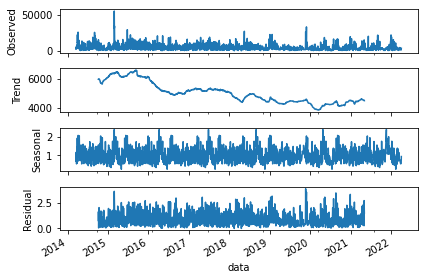

In [ ]:
# Error/Trend/Seasonality Models
N = 38
dataRunning2 = dataRunning.iloc[N:]
dataRunning2 = dataRunning2[dataRunning2.totale != 0.0]  #drop 55 occorrenze
# print(dataRunning2)
# dataRunning2 = dataRunning2.drop(columns = ['year', 'month'])
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataRunning2['totale'], model='multiplicative', freq=365)  # model='mul' also works
result.plot();

Stazionarietà del dataset -- AGGIUNGERE TEST COERENTE CON QUELLO DI AUTO ARIMA (ovvero kpss)

SEASONALITY --> fare test ocsb

In [ ]:
# import pmdarima
# result = OCSBTest(dataRunning['totale'].dropna(), 365)
# print(result)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(dataRunning['totale'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.304445e+01
p-value                 2.206546e-24
# lags used             5.000000e+00
# observations          2.265000e+03
critical value (1%)    -3.433240e+00
critical value (5%)    -2.862817e+00
critical value (10%)   -2.567450e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


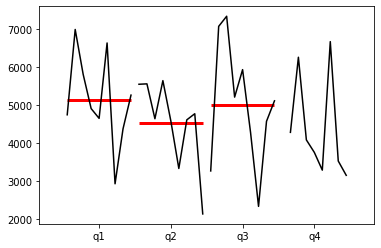

In [ ]:
from statsmodels.graphics.tsaplots import quarter_plot
dfq = dataRunning['totale'].resample(rule='Q').mean()

quarter_plot(dfq);

In [ ]:
dataRunning=dataRunning.reset_index()
# print(dataRunning)

# PROPHET

In [ ]:
from fbprophet import Prophet
import holidays

dataRunning.columns = ['ds','y']
dataRunning['ds'] = pd.to_datetime(dataRunning['ds'])

In [ ]:
train = dataRunning.iloc[:2211]
test = dataRunning.iloc[-2211:]

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphet(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet()
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1

    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    # num = np.sum(np.square(test_data['y'] - predictions))
    # den = np.sum(np.square(predictions))
    # squared_error = num/den
    # rrmse_loss = np.sqrt(squared_error)
    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2211
rmseProphet = rollingDaysProphet(dataRunning,train_end, 1, 14)
print(rmseProphet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2211    5342.888081
Name: yhat, dtype: float64
test data
2211    3247.51
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2212    4989.374831
Name: yhat, dtype: float64
test data
2212    22157.57
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2213    5473.74957
Name: yhat, dtype: float64
test data
2213    12892.61
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2214    6762.424464
Name: yhat, dtype: float64
test data
2214    20097.17
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2215    6711.451981
Name: yhat, dtype: float64
test data
2215    11079.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2216    6438.137365
Name: yhat, dtype: float64
test data
2216    19485.06
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2217    7163.806292
Name: yhat, dtype: float64
test data
2217    8023.26
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2218    6839.931381
Name: yhat, dtype: float64
test data
2218    5348.84
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2219    6418.700606
Name: yhat, dtype: float64
test data
2219    7830.32
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2220    6422.21657
Name: yhat, dtype: float64
test data
2220    4582.81
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2221    7425.365718
Name: yhat, dtype: float64
test data
2221    2674.42
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2222    6868.219109
Name: yhat, dtype: float64
test data
2222    502.14
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2223    6274.145624
Name: yhat, dtype: float64
test data
2223    8023.26
Name: y, dtype: float64
predictions
2224    6606.937704
Name: yhat, dtype: float64
test data
2224    2046.75
Name: y, dtype: float64
[64.52260596314406, 77.48230139336103, 57.54351081911305, 66.35135959942926, 39.42590727327748, 66.95859614796137, 10.712026131813355, 27.87691128355379, 18.027607993055273, 40.13708991120574, 177.6439645881285, 1267.7896818961572, 21.800544621982326, 222.80140239985653]


In [ ]:
print(test)

             ds         y
60   2014-04-08   2974.61
61   2014-04-09   5949.22
62   2014-04-10   7354.66
63   2014-04-11   8624.95
64   2014-04-12  11470.31
65   2014-04-14   4963.83
66   2014-04-15  14559.00
67   2014-04-16   3602.28
68   2014-04-17   2578.91
69   2014-04-18   4418.25
70   2014-04-19   3763.29
71   2014-04-21   7037.87
72   2014-04-24    955.15
73   2014-04-26   5949.22
74   2014-04-27    272.79
75   2014-04-29   6601.45
76   2014-04-30   6112.96
77   2014-05-01   8159.49
78   2014-05-02   6413.04
79   2014-05-03    953.24
80   2014-05-04    709.32
81   2014-05-05   1801.14
82   2014-05-07   2126.33
83   2014-05-08   1593.74
84   2014-05-09   3272.07
85   2014-05-10   7368.30
86   2014-05-11  13642.16
87   2014-05-12   5539.87
88   2014-05-13   3028.97
89   2014-05-14   4855.71
90   2014-05-15  10141.24
91   2014-05-17   4625.66
92   2014-05-18   2838.16
93   2014-05-19   4800.58
94   2014-05-20   7600.27
95   2014-05-21   8269.69
96   2014-05-22    436.53
97   2014-05

Prophet con variabile esogena relativa ai saldi

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataRunning.columns = ['ds','y']
# dataRunning['ds'] = pd.to_datetime(dataRunning['ds'])

In [ ]:
# train = dataRunning.iloc[:2211]
# test = dataRunning.iloc[-2211:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})


holidays = pd.concat((saldiInv, saldiEstivi, saldiBFNat))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetSaldi(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidays)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']

    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2211
rmsePrSaldi = rollingDaysProphetSaldi(dataRunning,train_end, 1, 14)
print(rmsePrSaldi)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2211    5161.683165
Name: yhat, dtype: float64
test data
2211    3247.51
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2212    4818.853259
Name: yhat, dtype: float64
test data
2212    22157.57
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2213    5351.297618
Name: yhat, dtype: float64
test data
2213    12892.61
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2214    6670.903146
Name: yhat, dtype: float64
test data
2214    20097.17
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2215    6651.69185
Name: yhat, dtype: float64
test data
2215    11079.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2216    6389.299904
Name: yhat, dtype: float64
test data
2216    19485.06
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2217    7177.393992
Name: yhat, dtype: float64
test data
2217    8023.26
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2218    6868.2382
Name: yhat, dtype: float64
test data
2218    5348.84
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2219    6422.333991
Name: yhat, dtype: float64
test data
2219    7830.32
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2220    6462.513122
Name: yhat, dtype: float64
test data
2220    4582.81
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2221    7469.767408
Name: yhat, dtype: float64
test data
2221    2674.42
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2222    6878.207044
Name: yhat, dtype: float64
test data
2222    502.14
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2223    6258.689119
Name: yhat, dtype: float64
test data
2223    8023.26
Name: y, dtype: float64
predictions
2224    6609.298921
Name: yhat, dtype: float64
test data
2224    2046.75
Name: y, dtype: float64
[58.94279510957979, 78.25188746234161, 58.4932948534003, 66.80675365515232, 39.96527129982, 67.20923669820581, 10.542672283191958, 28.40612544962111, 17.98120649895725, 41.01638780150388, 179.3042008279957, 1269.7787557992178, 21.99319080671622, 222.91676664527128]


Prophet con 2 variabili esogene: saldi e lockdown 

In [ ]:
# from fbprophet import Prophet
# import holidays

# dataRunning.columns = ['ds','y']
# dataRunning['ds'] = pd.to_datetime(dataRunning['ds'])

In [ ]:
# train = dataRunning.iloc[:2211]
# test = dataRunning.iloc[-2211:]

In [ ]:
saldiInv = pd.DataFrame({
  'holiday': 'saldiInv',
  'ds': pd.to_datetime(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05'
              #  '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
              #  '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
              #  '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
              #  '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
              #  '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
              #  '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
              #  '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
              #  '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
              #  '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
              #  '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
              #  '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
              #  '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
              #  '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
              #  '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
              #  '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
              #  '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
              #  '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
              #  '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
              #  '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
              #  '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
              #  '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
              #  '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
              #  '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
              #  '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
              #  '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
              #  '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
              #  '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
              #  '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
              #  '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
              #  '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiEstivi = pd.DataFrame({
  'holiday': 'saldiEstivi',
  'ds': pd.to_datetime(['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30'
              #  '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
              #  '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
              #  '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
              #  '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
              #  '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
              #  '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
              #  '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
              #  '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
              #  '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
              #  '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
              #  '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
              #  '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
              #  '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
              #  '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
              #  '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
              #  '2021-09-01'
              ]),
  'lower_window': 0,
  'upper_window': 1,
})

saldiBFNat = pd.DataFrame({
  'holiday': 'saldiBFNat',
  'ds': pd.to_datetime(['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']),
  'lower_window': 0,
  'upper_window': 1,
})

lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.to_datetime(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]),
  'lower_window': 0,
  'upper_window': 1,
})

holidaysCov = pd.concat((saldiInv, saldiEstivi, saldiBFNat, lockdown))

In [ ]:
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

def rollingDaysProphetCov(data, train_end, window, iter = 10):

  rmseList = list()
  

  for i in range(iter):
    m = Prophet(holidays=holidaysCov)
    train_data = data[:train_end]
    test_end = train_end + window
    test_data = data[train_end:test_end]
    train_end += 1
    
    m.fit(train_data)
    future = m.make_future_dataframe(periods=window,freq='D')
    forecast = m.predict(future)
    predictions = forecast.iloc[-window:]['yhat']
    
    print("predictions")
    print(predictions)

    print("test data")
    print(test_data['y'])

    EPSILON =  1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['y'] - predictions) / (test_data['y'] + EPSILON))))) * 100
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = 2211
rmsePrCovid = rollingDaysProphetCov(dataRunning,train_end, 1, 14)
print(rmsePrCovid)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2211    4901.357161
Name: yhat, dtype: float64
test data
2211    3247.51
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2212    4562.355747
Name: yhat, dtype: float64
test data
2212    22157.57
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2213    5128.300916
Name: yhat, dtype: float64
test data
2213    12892.61
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2214    6516.808221
Name: yhat, dtype: float64
test data
2214    20097.17
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2215    6495.626874
Name: yhat, dtype: float64
test data
2215    11079.74
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2216    6279.821163
Name: yhat, dtype: float64
test data
2216    19485.06
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2217    7103.867619
Name: yhat, dtype: float64
test data
2217    8023.26
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2218    6755.220683
Name: yhat, dtype: float64
test data
2218    5348.84
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2219    6315.049149
Name: yhat, dtype: float64
test data
2219    7830.32
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2220    6384.23821
Name: yhat, dtype: float64
test data
2220    4582.81
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2221    7401.990364
Name: yhat, dtype: float64
test data
2221    2674.42
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2222    6841.373262
Name: yhat, dtype: float64
test data
2222    502.14
Name: y, dtype: float64


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


predictions
2223    6188.913096
Name: yhat, dtype: float64
test data
2223    8023.26
Name: y, dtype: float64
predictions
2224    6546.838093
Name: yhat, dtype: float64
test data
2224    2046.75
Name: y, dtype: float64
[50.926622586304326, 79.40949414926513, 60.22294231899817, 67.57350302872715, 41.37383301413988, 67.77109661069825, 11.459087462397418, 26.293190354945157, 19.35132728707203, 39.308376511132046, 176.76993007929514, 1262.4433946197103, 22.862862521813515, 219.86505889806512]


# ARIMA

### Import pacchetti /// preprocessing sul dataset dedicato ad ARIMA

In [ ]:
datasetAR = pd.read_csv("serie-storiche-ecommerce-ARIMA.csv", sep =",")
pd.set_option('display.max_rows', None)

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.7 MB/s 
     |████████████████████████████████| 9.8 MB 49.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
datasetAR.index.name = "data"
#print(datasetAR.index.name)
datasetAR["totale"] = datasetAR["data"] + "." + datasetAR["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetAR["totale"]= datasetAR["totale"].str.replace("'","")
datasetAR=datasetAR.drop(columns="data")
#display(datasetAR)

In [ ]:
x = datasetAR["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetAR.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetAR["totale"]=datasetAR["totale"].astype(float)
datasetAR = datasetAR.reset_index()
#display(datasetAR) 

In [ ]:
dataRunningAR = datasetAR[datasetAR['settore'] == "Running"]

In [ ]:
!pip install cython
!pip install pmdarima
!pip install cuda-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 6.8 MB/s 


In [ ]:
dataRunningAR = dataRunningAR.set_index('data')
dataRunningAR.index = pd.to_datetime(dataRunningAR.index)

### ARIMA con Fourier

In [ ]:
from statsmodels.tools.eval_measures import rmse
from pmdarima.preprocessing import FourierFeaturizer

import warnings
warnings.filterwarnings("ignore")

def rollingDaysFourier(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]
  trans = FourierFeaturizer(365, 1)
  y_prime, X = trans.fit_transform(data)
  
  X['date'] = y_prime.index
  X = X.set_index('date')

  X_train = X[:train_end]
  
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=X_train, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    X_test = X[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # #model = SARIMAX(train_data, order=stepwise_fit.order, exog=X_train)
    # #fit the model
    # start = time()
    # #model_fit = stepwise_fit.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    # #get the predictions and residuals
    predictions = stepwise_fit.predict(window, X=X_test)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataRunningAR = dataRunningAR.drop(columns=['settore'])

In [ ]:
train_end = datetime(2021,12,31)
rmseARIMAFourier = rollingDaysFourier(dataRunningAR,train_end, 1, 14)
print(rmseARIMAFourier)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44017.587, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43473.406, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43010.116, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58832.941, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42986.598, Time=3.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=42993.978, Time=1.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43322.321, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=42998.230, Time=0.77 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 24.598 seconds
(1, 1, 1)
(0, 0, 0, 0)
real value               totale
data                
2022-01-01  22157.57
predictions                  totale
date                   
202

### ARIMA

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDays(data, train_end, window, iter = 10):

  rmseList = list()
  
  train_data = data[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)

    # print(train_end)
    # print(test_end)

    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)
    
    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
train_end = datetime(2021,12,31)
rmseAR = rollingDays(dataRunningAR,train_end, 1, 14)
print(rmseAR)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44013.587, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43469.409, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43006.160, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44011.587, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42982.653, Time=2.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=42990.027, Time=1.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=43318.327, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=42994.280, Time=0.49 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.128 seconds
(1, 1, 1)
(0, 0, 0, 0)
real value               totale
data                
2022-01-01  22157.57
predictions                  totale
date                   
202

### ARIMA con variabile esognena SALDI

In [ ]:
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 

In [ ]:
saldiInvernali = []
for i in range(len(dataRunningAR)):
  count = list(saldiInv).count(dataRunningAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataRunningAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataRunningAR)):
  count = list(saldiEst).count(dataRunningAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataRunningAR['saldi_Est'] = saldiEstivi


saldiBFNatale = []
for i in range(len(dataRunningAR)):
  count = list(saldiBFNat).count(dataRunningAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataRunningAR['saldi_BFNat'] = saldiBFNatale

# print(dataRunningAR)

dataRunningARExo = dataRunningAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldi(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    # fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)
    
  return rmseList

In [ ]:
dataRunningARExo = dataRunningARExo.drop(columns=['totale'])
dataRunningAR = dataRunningAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat'])

In [ ]:
rmseARIMASaldi = rollingDaysSaldi(dataRunningAR,train_end, dataRunningARExo, 1, 14)
print(rmseARIMASaldi)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=43019.744, Time=3.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44007.586, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43474.440, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43049.039, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58822.939, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=43015.960, Time=2.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=43028.470, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43034.608, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=43019.476, Time=2.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=43017.657, Time=1.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=43027.337, Time=1.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=43019.680, Time=5.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=2.94 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 22.022 seconds
(1, 1, 2)
(0, 

### ARIMA con variabili esogene SALDI e LOCKDOWN

In [ ]:
#saldi
import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today

listaInv = ['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13', '2014-01-14', '2014-01-15',
               '2014-01-16', '2014-01-17', '2014-01-18', '2014-01-19',
               '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23',
               '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27',
               '2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31',
               '2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
               '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
               '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
               '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
               '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
               '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
               '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
               '2014-03-05', 
               '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10',
               '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18',
               '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22',
               '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26',
               '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30',
               '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03',
               '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07',
               '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11',
               '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15',
               '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19',
               '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23',
               '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27',
               '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03',
               '2015-03-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
               '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
               '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
               '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
               '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
               '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
               '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
               '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04',
               '2016-03-05',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
               '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
               '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
               '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
               '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
               '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
               '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
               '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
               '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
               '2017-03-02', '2017-03-03', '2017-03-04', '2017-03-05',             
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28',
               '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01',
               '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05',
               '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17',
               '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25',
               '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24',
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
               '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05'
              ]

listaEst = ['2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10', '2014-07-11', '2014-07-12',
               '2014-07-13', '2014-07-14', '2014-07-15', '2014-07-16',
               '2014-07-17', '2014-07-18', '2014-07-19', '2014-07-20',
               '2014-07-21', '2014-07-22', '2014-07-23', '2014-07-24',
               '2014-07-25', '2014-07-26', '2014-07-27', '2014-07-28',
               '2014-07-29', '2014-07-30', '2014-07-31', '2014-08-01',
               '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05',
               '2014-08-06', '2014-08-07', '2014-08-08', '2014-08-09',
               '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13',
               '2014-08-14', '2014-08-15', '2014-08-16', '2014-08-17',
               '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21',
               '2014-08-22', '2014-08-23', '2014-08-24', '2014-08-25',
               '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-09-03', 
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
               '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23',
               '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27',
               '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31',
               '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04',
               '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08',
               '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12',
               '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16',
               '2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02',
               '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05',
               '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09',
               '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13',
               '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17',
               '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21',
               '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25',
               '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29',
               '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02',
               '2016-08-03', '2016-08-04', '2016-08-05', '2016-08-06',
               '2016-08-07', '2016-08-08', '2016-08-09', '2016-08-10',
               '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14',
               '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18',
               '2016-08-19', '2016-08-20', '2016-08-21', '2016-08-22',
               '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-26',
               '2016-08-27', '2016-08-28', '2016-08-29', '2016-08-30',
               '2016-08-31',
               '2017-07-01', '2017-07-02', '2017-07-03', '2017-07-04',
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-15', '2017-07-16',
               '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30',
               '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10',
               '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14',
               '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05',
               '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01', '2019-09-02', '2019-09-03',
               '2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
               '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
               '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30',
               '2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06',
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01'
              ]
listaBFNat = ['2014-11-15', '2014-11-16', '2014-11-17', '2014-11-18',
               '2014-11-19', '2014-11-20', '2014-11-21', '2014-11-22',
               '2014-11-23', '2014-11-24', '2014-11-25', '2014-11-26',
               '2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
               '2014-12-01', '2014-12-02', '2014-12-03', '2014-12-04',
               '2014-12-05', '2014-12-06', '2014-12-07', '2014-12-08',
               '2014-12-09', '2014-12-10', '2014-12-11', '2014-12-12',
               '2014-12-13', '2014-12-14', '2014-12-15',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
               '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15',
               '2016-11-15', '2016-11-16', '2016-11-17', '2016-11-18',
               '2016-11-19', '2016-11-20', '2016-11-21', '2016-11-22',
               '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26',
               '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
               '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15',
               '2017-11-15', '2017-11-16', '2017-11-17', '2017-11-18',
               '2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-02', '2017-12-03', '2017-12-04',
               '2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-09', '2017-12-10', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14', '2017-12-15',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22',
               '2018-11-23', '2018-11-24', '2018-11-25', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-08',
               '2018-12-09', '2018-12-10', '2018-12-11', '2018-12-12',
               '2018-12-13', '2018-12-14', '2018-12-15', 
               '2019-11-15', '2019-11-16', '2019-11-17', '2019-11-18',
               '2019-11-19', '2019-11-20', '2019-11-21', '2019-11-22',
               '2019-11-23', '2019-11-24', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-07', '2019-12-08',
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-14', '2019-12-15',
               '2020-11-15', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
               '2021-12-13', '2021-12-14', '2021-12-15']

saldiInv = set([])
for i in listaInv:
  data = asDate(i)
  saldiInv.add(data)

saldiEst = set([])
for i in listaEst:
  data = asDate(i)
  saldiEst.add(data)

saldiBFNat = set([])
for i in listaBFNat:
  data = asDate(i)
  saldiBFNat.add(data) 


# lockdown 9/3/2020 - 18/05/2020
# zona rossa: nov 2020 + dic 2020 + fino al 10/01 2021
            # da 10/03/21 a fine aprile 21

import datetime

def asDate(stringa):
  today = datetime.datetime.strptime(stringa, "%Y-%m-%d")
  return today


listLock1 = ['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]


listLock = set([])
for i in listLock1:
  data = asDate(i)
  listLock.add(data)

In [ ]:
#saldi
saldiInvernali = []
for i in range(len(dataRunningAR)):
  count = list(saldiInv).count(dataRunningAR.index[i])
  if(count > 0):
    saldiInvernali.append(1)
  else: 
    saldiInvernali.append(0)

dataRunningAR['saldi_inv'] = saldiInvernali


saldiEstivi = []
for i in range(len(dataRunningAR)):
  count = list(saldiEst).count(dataRunningAR.index[i])
  if(count > 0):
    saldiEstivi.append(1)
  else: 
    saldiEstivi.append(0)

dataRunningAR['saldi_Est'] = saldiEstivi

saldiBFNatale = []
for i in range(len(dataRunningAR)):
  count = list(saldiBFNat).count(dataRunningAR.index[i])
  if(count > 0):
    saldiBFNatale.append(1)
  else: 
    saldiBFNatale.append(0)

dataRunningAR['saldi_BFNat'] = saldiBFNatale

#lockdown
listLockdown = []
for i in range(len(dataRunningAR)):
  count = list(listLock).count(dataRunningAR.index[i])
  if(count > 0):
    listLockdown.append(1)
  else: 
    listLockdown.append(0)

dataRunningAR['lockdown'] = listLockdown

# print(dataRunningAR)

dataRunningARExo = dataRunningAR

In [ ]:
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

def rollingDaysSaldiCovid(data, train_end, exog, window, iter = 10):

  rmseList = list()

  train_data = data[:train_end]
  train_exog = exog[:train_end]
  stepwise_fit = auto_arima(train_data, seasonal=False, exogenous=train_exog, error_action='ignore', suppress_warnings=True, trace =True)

  for i in range(iter):
    test_end = train_end+timedelta(days=window)
    test_data = data[train_end + timedelta(days=1):test_end]
    test_exog = exog[train_end + timedelta(days=1):test_end]
    train_end += timedelta(days=1)


    # print(train_end)
    # print(test_end)
        
    print(stepwise_fit.order)
    print(stepwise_fit.seasonal_order)
    # model = SARIMAX(train_data, order=stepwise_fit.order, exog=train_exog, seasonal_order=stepwise_fit.seasonal_order)
    #fit modello
    # start = time()
    # model_fit = model.fit()
    # end = time()
    # print('Model Fitting Time:', end - start)
    #predictions e residuals
    predictions = stepwise_fit.predict(window, X=test_exog)
    predictions = pd.DataFrame({'date':test_data.index[0] ,'totale':predictions})
    residuals = test_data.totale - predictions.totale
    predictions = predictions.set_index('date')
    # predictions.index = pd.to_datetime(predictions.index)
    # print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.totale)),4))
    # print('Root Mean Squared Error:', (rmse(test_data['totale'], predictions['totale'])))
    print('real value', test_data)
    print('predictions', predictions)

    EPSILON = 1e-10
    rmspe = (np.sqrt(np.mean(np.square((test_data['totale'] - predictions['totale']) / (test_data['totale'] + EPSILON)), axis=0))) * 100
    print(rmspe)
    rmseList.append(rmspe)

  return rmseList

In [ ]:
dataRunningARExo = dataRunningARExo.drop(columns=['totale'])
dataRunningAR = dataRunningAR.drop(columns=['saldi_inv', 'saldi_Est', 'saldi_BFNat', 'lockdown'])

In [ ]:
rmseARIMASaldiCovid = rollingDaysSaldiCovid(dataRunningAR,train_end, dataRunningARExo, 1, 14)
print(rmseARIMASaldiCovid)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=43020.261, Time=2.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44009.391, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43475.596, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43050.058, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58824.745, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=43027.921, Time=1.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=43022.023, Time=1.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=43020.275, Time=5.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43035.390, Time=1.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=43019.984, Time=2.45 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=43018.179, Time=1.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=43029.274, Time=0.99 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=43019.284, Time=1.69 sec
 ARIMA(1,1,4)(0,0,0)[0] i

### Tabella per confrontare gli RMSE ottenuti dai vari modelli

In [ ]:
risultati = pd.DataFrame({'rmseProphet': rmseProphet, 'rmseProphetSaldi': rmsePrSaldi, 'rmseProphetCovid': rmsePrCovid, 'rmseARIMAFourier': rmseARIMAFourier, 'rmseARIMA': rmseAR, 'rmseARIMASaldi': rmseARIMASaldi, 'rmseARIMASaldiCovid': rmseARIMASaldiCovid})
risultati

,rmseProphet,rmseProphetSaldi,rmseProphetCovid,rmseARIMAFourier,rmseARIMA,rmseARIMASaldi,rmseARIMASaldiCovid
0,64.522606,58.942795,50.926623,80.716164,80.817830,69.887439,72.868761
1,77.482301,78.251887,79.409494,66.838976,67.033031,48.247780,53.371557
2,57.543511,58.493295,60.222942,78.714423,78.851238,66.800242,70.087215
3,66.351360,66.806754,67.573503,61.368590,61.638967,39.780068,45.742199
4,39.425907,39.965271,41.373833,78.020573,78.186864,64.359696,67.750031
5,66.958596,67.209237,67.771097,46.591136,47.025240,13.444977,21.678646
6,10.712026,10.542672,11.459087,19.841656,20.537860,29.832535,17.482031
7,27.876911,28.406125,26.293190,45.213830,45.719936,11.312251,19.748799
8,18.027608,17.981206,19.351327,6.339040,7.255532,51.534420,37.119493
9,40.137090,41.016388,39.308377,60.582676,58.924280,159.665069,134.964061
